# DSFB 2019 Project - Team 3: Solutions

Team members:
![image.png](attachment:image.png)

## IMPORTS

Here are a bunch of libraries that you may need to use...

In [217]:
import numpy  as np
import pandas as pd

import itertools
import random
import math  
import copy

import pandas_profiling

# Plotting
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as patches
%matplotlib inline  
import seaborn as sns
sns.set(style="white")

# scikit-learn
from sklearn.dummy           import DummyClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.svm             import SVC
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.ensemble        import RandomForestClassifier
from sklearn.ensemble        import GradientBoostingClassifier

# Supporting functions from scikit-learn
from sklearn.metrics         import confusion_matrix
from sklearn.metrics         import roc_curve
from sklearn.metrics         import roc_auc_score
from sklearn.pipeline        import Pipeline
from sklearn.preprocessing   import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree            import export_graphviz
from sklearn.decomposition   import PCA

# for text processing
import spacy
import re
import nltk
from nltk.corpus import stopwords

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel, LdaModel, LdaMulticore, LsiModel, HdpModel

# ignore some warnings 
import warnings
warnings.filterwarnings('ignore')

# Set a seed for replication
SEED = 1  # Use this anywhere a stochastic function allows you to set a seed

# Additional imports
import missingno as msno
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score
from gensim.models import LdaModel, LdaMulticore, LsiModel, HdpModel
from sklearn.model_selection import validation_curve
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import StratifiedKFold

# Special Plotting
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

## Useful function definitions

In [121]:
def plot_confusion_matrix(cm, classes=[0,1], normalize=False, title='Confusion Matrix', cmap=plt.cm.Reds):
    """ 
    Function to plot a sklearn confusion matrix, showing number of cases per prediction condition. 
    The cm parameter can be an object created by the sklearn confusion_matrix() function.
    
    Args:
        cm         this must be a sklearn confusion matrix 
        classes    levels of the class being predicted; default to binary outcome
        normalize  apply normalization by setting `normalize=True`
        title      title for the plot
        cmap       color map
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, round (cm[i, j],2), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    

def plot_roc(fpr, tpr, title='ROC Curve', note=''):
    """
    Function to plot an ROC curve in a consistent way.
    The fpr and tpr parameters can be created by the sklearn roc_curve() function.
    
    Args:
        fpr        False Positive Rate (list of multiple points)
        tpr        True Positive Rate (list of multiple points)
        title      Title above the plot
        note       Note to display in the bottom-right of the plot
    """
    plt.figure(1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr, tpr)
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title(title)
    if note: plt.text(0.6, 0.2, note)
    plt.show()
    
def print_feature_importance(tree_model, feature_names):
    """
    Function to print a list of features from an sklearn tree model (ranked by importance of the feature)
    
    Args:
        tree_model       A sklearn DecisionTreeClassifier()
        feature_names    A list of features used by the DecisionTreeClassifier
    """
    print('Feature'.center(12), '   ',  'Importance')
    print('=' * 30)
    for index in reversed(np.argsort(tree_model.feature_importances_)):
        print(str(feature_names[index]).center(12) , '   ', '{0:.4f}'.format(tree_model.feature_importances_[index]).center(8)) 
        
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model=LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, alpha='auto', eta='auto', random_state=SEED)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append((coherencemodel.get_coherence(), num_topics))
        print(f"Number of topics : {num_topics}, Coherence score : {coherence_values[-1][0]:.3f}")

    return model_list, coherence_values        

In [642]:
def plot_validation_curve(train_scores, cv_scores, x_data, y_label='', x_label='', x_logscale=False):
    
    plt.title('Validation Curve')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.ylim(0.0, 1.1)
    
    train_scores_mean = np.mean(train_scores, axis=1)
    cv_scores_mean    = np.mean(cv_scores,    axis=1)
    
    if x_logscale:
        plt.semilogx(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.semilogx(x_data, cv_scores_mean,    'o-', color="g",  label="Cross-validation score")        
    else:
        plt.plot(x_data, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(x_data, cv_scores_mean,    'o-', color="g", label="Cross-validation score")
        
    plt.legend(loc='center')
    plt.show()

In [3]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx")
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [4]:
df_learn.shape

(3330, 47)

**Load data**: We notice that the first column in the data has unique ID, not an useful feature for prediction.

In [5]:
len(set(df_learn[df_learn.columns[0]].to_list()))

3330

Reload the data with first column as index

In [6]:
df_learn=pd.read_excel("IPO_data_to_learn.xlsx", index_col=0)
df_predict=pd.read_excel("IPO_data_to_predict.xlsx", index_col=0)

# Quick look at the data and observations

In [7]:
df_learn.info(verbose=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3330 entries, 974 to 1741
Data columns (total 46 columns):
closeDay1             3215 non-null float64
offerPrice            3330 non-null float64
rf                    3057 non-null object
egc                   3330 non-null bool
html                  3330 non-null bool
patRatio              2055 non-null float64
city                  3329 non-null object
issuer                3330 non-null object
highTech              3330 non-null bool
age                   3148 non-null float64
exchange              3330 non-null object
year                  3330 non-null int64
industryFF5           3330 non-null object
industryFF12          3330 non-null object
industryFF48          3330 non-null object
nUnderwriters         3330 non-null int64
sharesOfferedPerc     3068 non-null float64
totalProceeds         3330 non-null int64
manager               3330 non-null object
investmentReceived    1830 non-null float64
amountOnProspectus    3330 non-nul

**Comments**: We observe that there 46 columns out of which 38 are numeric/bool and 8 are text type. We also notice that there are some missing data in many fields. 

Now we look at the detailed profile of the dataFrame using pandas profiling. (The report is provided in HTML along with the submission. Observations related to the report are given below).

In [8]:
#file.profile_report()
profile = pandas_profiling.ProfileReport(df_learn)
profile.to_file(outputfile='learn_data_profile_report.html')

**Observations from the profile report**

* Presence of missing values (Either drop or process the missig fileds)
* High correlation among 5 fields (May be ignored or Use PCA to reduce the dimentionality)
* Different scales, ranging from 0 to 1e9. (Need to normalize the data)
* Missing outcome: offerPrice(3.5%) and closeDay1(3.5%). Since there is no outcome, it may not be useful to use this data, may be dropped.
* Only 22% of the companies are marked emerging growth companies. (Possibility of bias?)
* Most of the companies are listed in NASDAQ(2368), followed by NYSE(895)
* Data is present from 1996 to 2018 (More data in the late 90s, but data is well spread across years)
* Five fields that are skewed (totalProceeds, InvestmentReceived, commonEquity1, totalRevenue, nPatents)
* 19 fileds out of 47 have missing entries. Highest missing entries in investmentReceived(45%) followed by nExecutives, priorFinancing, nVCs, patRatio, managementFee(32.9%) in descending order

In [9]:
# Profile report for the prediction data
profile = pandas_profiling.ProfileReport(df_predict)
profile.to_file(outputfile='predict_data_profile_report.html')

In [8]:
data = copy.copy(df_learn)

We do exploratory analysis of the data and missing fields in the cells below

Missing data dristribution across various fields is shown below

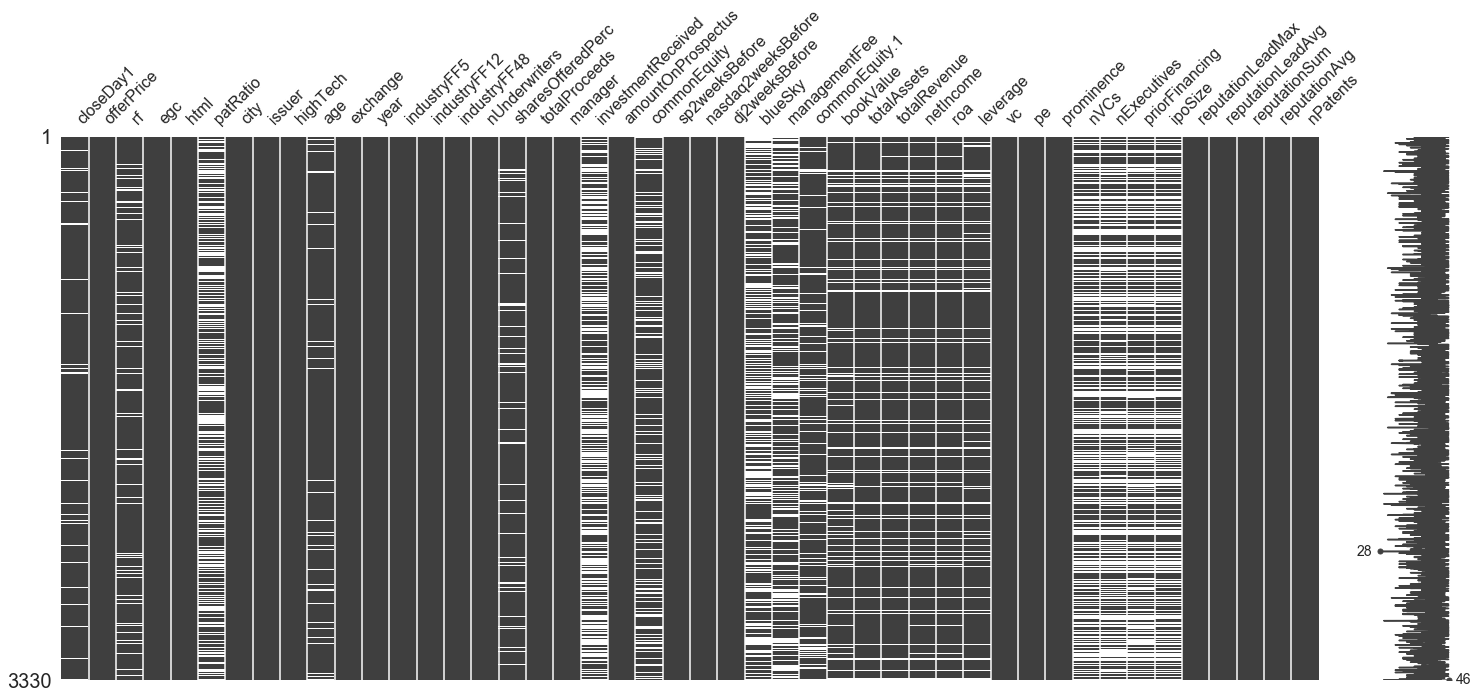

In [9]:
msno.matrix(data)

**Comment** : Write what the following cell does

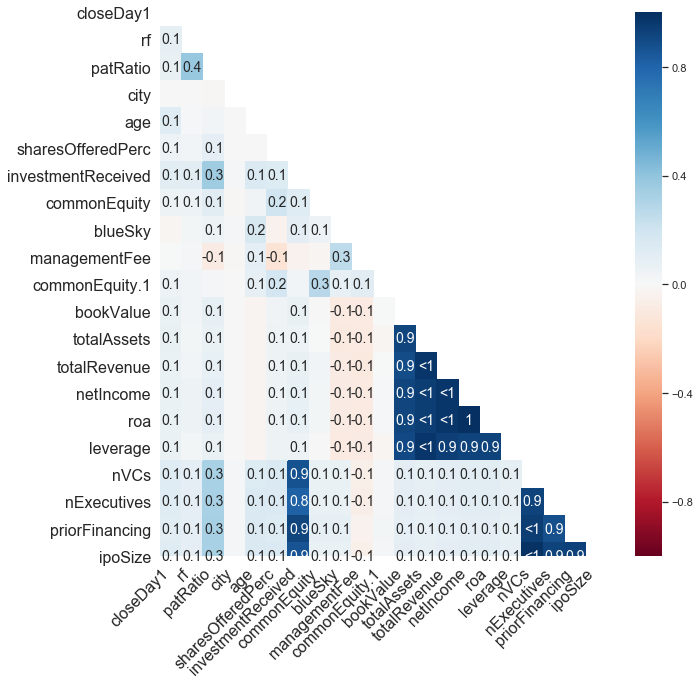

In [10]:
incomplete = data.columns[data.isnull().any()].tolist()
msno.heatmap(data[incomplete], figsize=(10,10))

**Comment**: The following cell shows the correlation among the datafields.

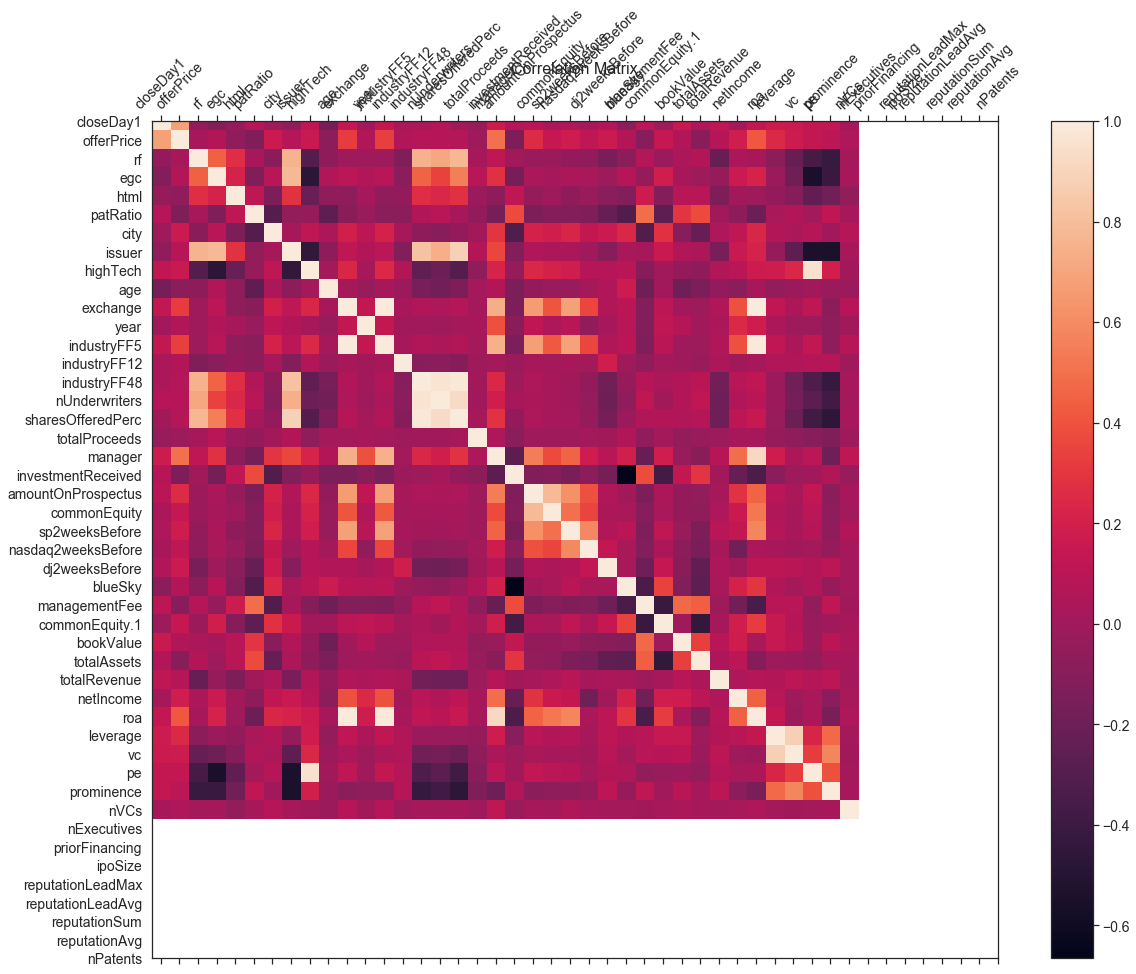

In [11]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(data.corr(), fignum=f.number)
plt.xticks(range(data.shape[1]), data.columns, fontsize=14, rotation=45)
plt.yticks(range(data.shape[1]), data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

**Observations**: We notice that most of the fields are weakly correlated. However, there are few features that has strong positive and negative correlations.

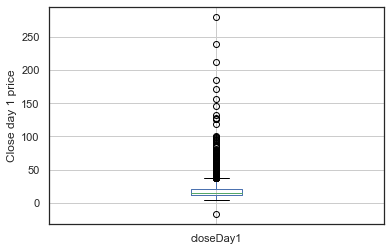

In [12]:
# Distribution of the Close day 1
data.boxplot(column='closeDay1')
plt.ylabel('Close day 1 price')
plt.show()

In [13]:
df_learn['exchange'].value_counts()

NASDQ    2368
NYSE      895
AMEX       67
Name: exchange, dtype: int64

In [14]:
df_learn['industryFF5'].value_counts()

Business Equipment, Telephone and Television Transmission                                         1122
Other                                                                                              898
Healthcare, Medical Equipment, and Drugs                                                           621
Consumer Durables, NonDurables, Wholesale, Retail, and Some Services (Laundries, Repair Shops)     393
Manufacturing, Energy, and Utilities                                                               296
Name: industryFF5, dtype: int64

In [15]:
df_learn['industryFF12'].value_counts().head()

Business Equipment -- Computers, Software, and Electronic Equipment    945
Healthcare, Medical Equipment, and Drugs                               621
Finance                                                                483
Other                                                                  462
Wholesale, Retail, and Some Services (Laundries, Repair Shops)         271
Name: industryFF12, dtype: int64

In [16]:
df_learn['industryFF48'].value_counts().head()

Business Services          845
Pharmaceutical Products    409
Trading                    221
Electronic Equipment       190
Retail                     158
Name: industryFF48, dtype: int64

**Comments**: Will probably need to only keep 1 of these, maybe FF12?


In [17]:
df_learn = df_learn.rename(columns={"commonEquity":"commonEquity1","commonEquity.1":"commonEquity2" })

**Comments**: Age is the age of the firm. Should replace mising values by the mean? Are the zeros indicating new firms?

In [18]:
print(df_learn['age'].mean())
print(df_learn['age'].mode())

16.184561626429478
0    3.0
dtype: float64


In [19]:
len([w for w in df_learn['age'] if w>100])

53

**Comments**: Is it possible to have so much old companies?

In [20]:
print(df_learn['blueSky'].median(), df_learn['blueSky'].mean())

10000.0 12916.115884115885


**Comments**: Should do something with *blue sky* missing value: need to decide if really useful and, if it is, how to fill it. mean, median or mean between 1sr and 3rd quarter

# Part 1: data cleaning and preprocessing


In [335]:
processed_data = copy.deepcopy(df_learn)

## Part 1A : Replacing the null fields
**Comment**: In the following cells, we replace or drop the null fields using appropriate logic for that perticular field

In [336]:
processed_data.replace([np.inf, -np.inf], np.nan, inplace=True)

In [337]:
processed_data['age'].fillna(processed_data['age'].median(), inplace=True)

In [338]:
processed_data['blueSky'].fillna(processed_data['blueSky'].median(), inplace=True)

We decide to drop the data corresponding to missing or negative values of 'closeDay1' as this feature is very important and so replacing missing values may lead to huge misinterpretation. Moreover it corresponds to only 3.5% of the data


In [339]:
processed_data.dropna(subset=["closeDay1"], inplace=True)

**Comment** : We fill the null "Risk factor" field with ""

In [340]:
processed_data.rf.fillna("", inplace=True)

In [341]:
processed_data['patRatio'].fillna(processed_data['patRatio'].median(), inplace=True)

In [342]:
replace_mean = ["sharesOfferedPerc", "investmentReceived", "commonEquity1", "managementFee", "commonEquity2", "bookValue", "totalAssets", "totalRevenue", "netIncome", "roa", "leverage", "priorFinancing", "ipoSize"]

In [343]:
processed_data[replace_mean].head(2)

,sharesOfferedPerc,investmentReceived,commonEquity1,managementFee,commonEquity2,bookValue,totalAssets,totalRevenue,netIncome,roa,leverage,priorFinancing,ipoSize
974,30.50,64190.0,NaN,924417.0,100.00,219.134116,240.974,23.34,-48.811,-0.202557,0.000000,64190.0,68114956.0
2585,17.09,NaN,0.063,NaN,40.99,231.418979,2190.648,142.89,15.918,0.007266,0.155445,NaN,NaN


In [344]:
processed_data[replace_mean] = processed_data[replace_mean].apply(lambda x: x.fillna(x.mean()),axis=0)

In [345]:
replace_median = ["nExecutives", "nVCs"]

In [346]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,NaN,NaN


In [347]:
processed_data[replace_median] = processed_data[replace_median].apply(lambda x: x.fillna(x.median()),axis=0)

In [348]:
processed_data[replace_median].head(2)

,nExecutives,nVCs
974,5.0,5.0
2585,11.0,6.0


In [349]:
processed_data.shape

(3215, 46)

#data.profile_report()

Referring to the profile report generated, attached as HTML along with submission.

We can see that some features are highly correlated, so we will use PCA to remove the redundant features.

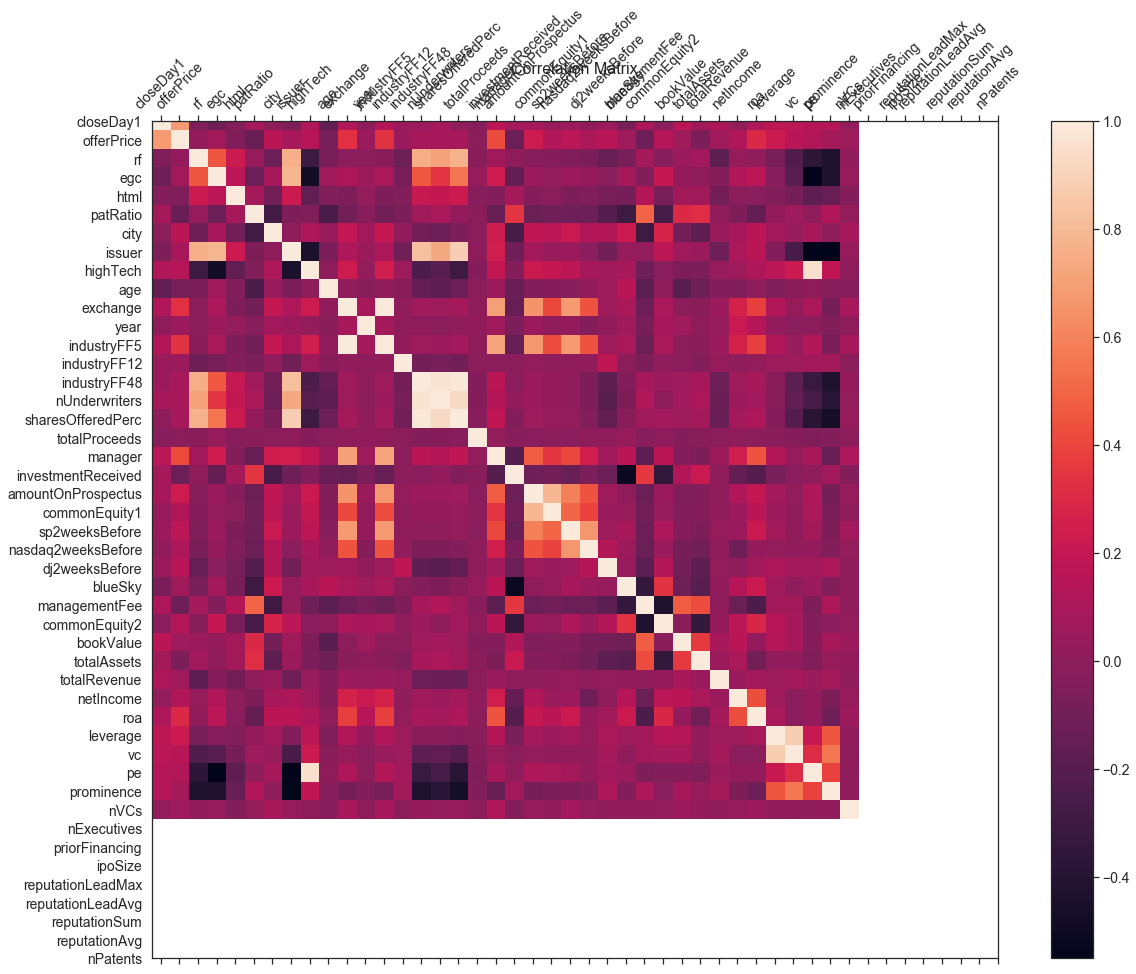

In [350]:
#Plot correlation matrix
f = plt.figure(figsize=(19, 15))
plt.matshow(processed_data.corr(), fignum=f.number)
plt.xticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14, rotation=45)
plt.yticks(range(processed_data.shape[1]), processed_data.columns, fontsize=14)
cb = plt.colorbar()
cb.ax.tick_params(labelsize=14)
plt.title('Correlation Matrix', fontsize=16);

The following cell shows that all the filed are pre-processed. Since there are no null fields. Also notice that the number of rows have reduced.

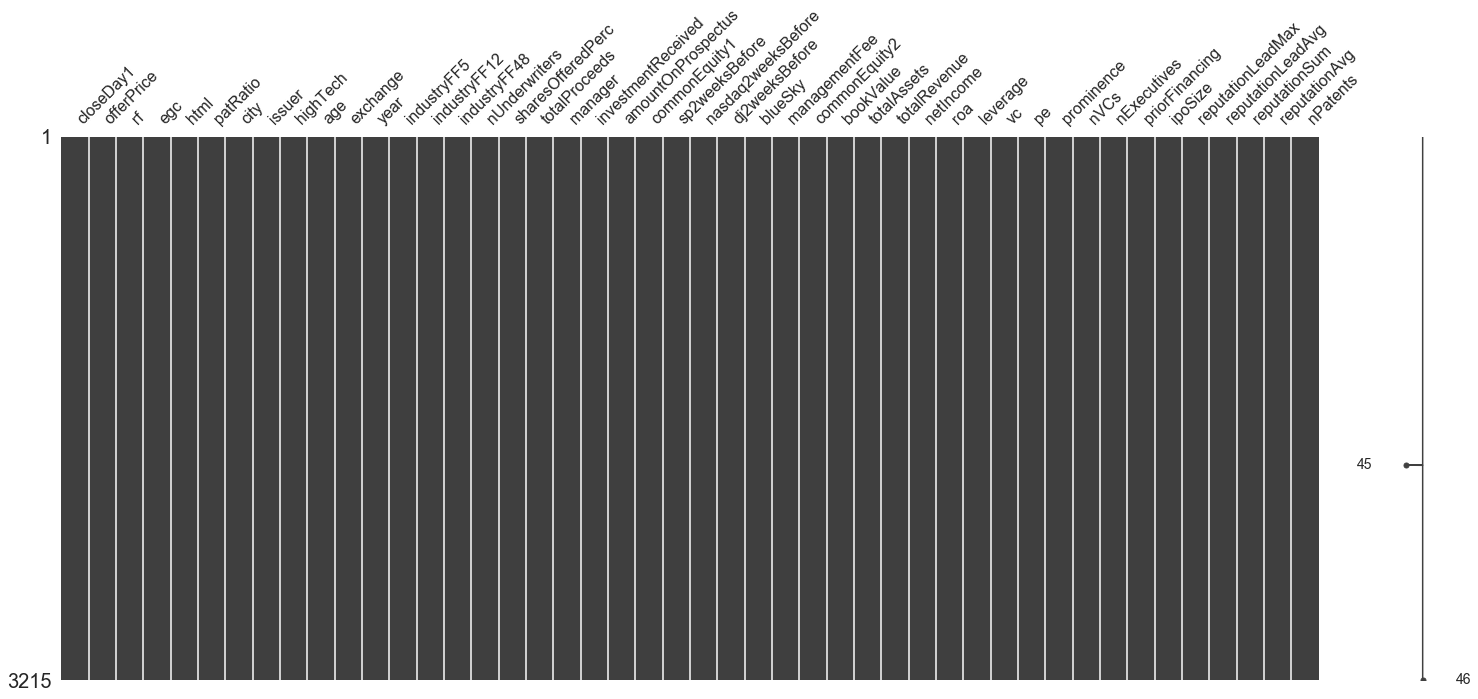

In [351]:
msno.matrix(processed_data)

## Part 1B: Processing the fields (Addition, deletion)

**Comments**

1. 'issuer' is unique, hence will not be a useful feature for prediction. We drop it from the list of useful features and set it as index.
2. 'Exchange' is categorical (3 distinct values). We create dummies
3. 'IndustryFF12' is also categorical (5 distinct values)
4. ['manager', 'city'] have high cardinality, hence dropped from the useful features
5. Update True/False fields to 1/0

In [352]:
# Unique field 'issuer' is made index of the cell
processed_data.set_index('issuer', drop=True, inplace=True)

In [353]:
processed_data = pd.get_dummies(data=processed_data, columns= ['exchange', 'industryFF12'])

In [354]:
processed_data.drop(['manager', 'city'], axis=1, inplace=True)

In [355]:
# Creating additional field for return and raisingPrice(upORdown)
processed_data['return'] = (processed_data['closeDay1'] - processed_data['offerPrice'])/(processed_data['offerPrice'] + 1e-10)
processed_data["raisingPrice"] = (processed_data["return"] > 0).astype(int)

In [356]:
processed_data[processed_data.select_dtypes([np.bool]).columns] = processed_data.select_dtypes([np.bool]).astype(int)

In [357]:
y = np.array(processed_data['raisingPrice'])

In [358]:
y.shape

(3215,)

In [359]:
processed_data.columns

Index(['closeDay1', 'offerPrice', 'rf', 'egc', 'html', 'patRatio', 'highTech',
       'age', 'year', 'industryFF5', 'industryFF48', 'nUnderwriters',
       'sharesOfferedPerc', 'totalProceeds', 'investmentReceived',
       'amountOnProspectus', 'commonEquity1', 'sp2weeksBefore',
       'nasdaq2weeksBefore', 'dj2weeksBefore', 'blueSky', 'managementFee',
       'commonEquity2', 'bookValue', 'totalAssets', 'totalRevenue',
       'netIncome', 'roa', 'leverage', 'vc', 'pe', 'prominence', 'nVCs',
       'nExecutives', 'priorFinancing', 'ipoSize', 'reputationLeadMax',
       'reputationLeadAvg', 'reputationSum', 'reputationAvg', 'nPatents',
       'exchange_AMEX', 'exchange_NASDQ', 'exchange_NYSE',
       'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
       'industryFF12_Chemicals and Allied Products',
       'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
       'industryFF12_Consumer NonDurables -- Food, Tobacco, Textile

## Part 1C: Text pre-process on Risk Factor

In [360]:
# Get English Stopwords from NLTK & Extend the stop word list
stop_words = stopwords.words('english')
stop_words.extend(['risk', 'factor', 'company', 'stock', 'may', 'inc', 'co', 'result', 'financial', \
               'portfolio', 'business', 'market', 'customer', 'service', 'price', 'management', \
              'product', 'operation', 'adversely', 'new', 'revenue', 'sale', 'operating', \
                   'adverse', 'effect', 'consider', 'careful', 'need', 'cost', 'information', 'investment'
              ])


In [361]:
print(len(stop_words), stop_words[:10])
''.join(stop_words).__contains__('could')

210 ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


True

In [362]:
#looks how many percent of risk facor are NaN values
processed_data['rf'].isna().sum()/len(processed_data['rf'])

0.0

In [363]:
#file them with a blank
processed_data['rf'] = processed_data['rf'].fillna('')

In [364]:
# Define a custom function to clean some given text
import string
def clean_re(txt):
    txt = re.sub(f"[{string.punctuation}]", "", str(txt))
    
    return txt

In [365]:
# Test clean_re
txt = "akjdf!!@#$%^&*()_/*965214"
clean_re(txt)

'akjdf965214'

In [366]:
# Apply clean_re() to all features
processed_data['rf'] = processed_data['rf'].apply(clean_re)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       RISK FACTORS You should carefully consider the...
Home BancShares Inc,Conway,AR    risk factors an investment in our common stock...
Name: rf, dtype: object

In [367]:
wnl=nltk.stem.WordNetLemmatizer()

def lemmatize_text(txt):
    return ' '.join([wnl.lemmatize(t.lower()) for t in txt.split(' ')])

In [368]:
# Apply lemmatize_text() to all features  
processed_data['rf'] = processed_data['rf'].apply(lemmatize_text)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       risk factor you should carefully consider the ...
Home BancShares Inc,Conway,AR    risk factor an investment in our common stock ...
Name: rf, dtype: object

In [369]:
lnl=nltk.stem.LancasterStemmer()

def lemmatize_text(txt):
    return ' '.join([wnl.lemmatize(t.lower()) for t in txt.split(' ')])

In [370]:
# Apply lemmatize_text() to all features  
processed_data['rf'] = processed_data['rf'].apply(lemmatize_text)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       risk factor you should carefully consider the ...
Home BancShares Inc,Conway,AR    risk factor an investment in our common stock ...
Name: rf, dtype: object

In [371]:
# Define custom function to remove stopwords
def clean_stopwords(txt):
    li = list(txt.lower().split(" "))
    txt = [word for word in li if word not in stop_words]
    return ' '.join(txt)

#pattern = re.compile(r'(?i)\b(' + r'|'.join(stop_words) + r')\b\s*')
#def clean_stopwords(txt):
#    txt = pattern.sub('', txt)
#    return txt 

In [372]:
# Test clean_stopwords
txt = " ".join(stop_words).lower()
print("**All stop words**:", txt)
clean_stopwords(txt)

**All stop words**: i me my myself we our ours ourselves you you're you've you'll you'd your yours yourself yourselves he him his himself she she's her hers herself it it's its itself they them their theirs themselves what which who whom this that that'll these those am is are was were be been being have has had having do does did doing a an the and but if or because as until while of at by for with about against between into through during before after above below to from up down in out on off over under again further then once here there when where why how all any both each few more most other some such no nor not only own same so than too very s t can will just don don't should should've now d ll m o re ve y ain aren aren't couldn couldn't didn didn't doesn doesn't hadn hadn't hasn hasn't haven haven't isn isn't ma mightn mightn't mustn mustn't needn needn't shan shan't shouldn shouldn't wasn wasn't weren weren't won won't wouldn wouldn't risk factor company stock may inc co result 

''

In [373]:
# Apply function to remove stopwords
processed_data['rf'] = processed_data['rf'].apply(clean_stopwords)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       carefully following contained prospectus purch...
Home BancShares Inc,Conway,AR    common involves making decision carefully desc...
Name: rf, dtype: object

In [374]:
# Define custom function to wrap simple_preprocess() from gensim
#def sp(txt):
#    return simple_preprocess(txt)

# Define custom function to wrap simple_preprocess() from gensim
def wrap_simple_preprocess(txt):
    return simple_preprocess(str(txt))

In [375]:
# Apply simple_preprocess() to all features
processed_data['rf'] = processed_data['rf'].apply(wrap_simple_preprocess)    
processed_data['rf'].head(2)

issuer
Numerical Technologies Inc       [carefully, following, contained, prospectus, ...
Home BancShares Inc,Conway,AR    [common, involves, making, decision, carefully...
Name: rf, dtype: object

# Part 2: Feature extraction

Choose most relevant features for each of the model and justification

Logit : Baseline : Linear :Knn:Kmeans :SVC:Decision trees:Random forests:Splines:

## Part 2A: Extracting features from 'rf'

In this section, we utilize NLP to process risk factors and extract useful features for prediction.
Reference: [web link](https://markroxor.github.io/gensim/static/notebooks/gensim_news_classification.html)

In [376]:
#processed_data = processed_data

### Topic models

We try various topic models (LSI, HDA, LDA) and select one of them based on the coherence score.

In [377]:
id2word = corpora.Dictionary(processed_data['rf'])
corpus = [id2word.doc2bow(doc) for doc in processed_data['rf']]

In [378]:
no_topics = 10
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word, num_topics=no_topics, random_state=SEED,
)

In [379]:
cm_lda = CoherenceModel(model=lda_model, texts=processed_data["rf"], dictionary=id2word)
print(f"Coherence score : {cm_lda.get_coherence():.3f}")

Coherence score : 0.311


In [380]:
lda_models, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=processed_data.rf, start=2, limit=15, step=1)

Number of topics : 2, Coherence score : 0.295
Number of topics : 3, Coherence score : 0.293
Number of topics : 4, Coherence score : 0.310
Number of topics : 5, Coherence score : 0.291
Number of topics : 6, Coherence score : 0.296
Number of topics : 7, Coherence score : 0.302
Number of topics : 8, Coherence score : 0.296
Number of topics : 9, Coherence score : 0.314
Number of topics : 10, Coherence score : 0.311
Number of topics : 11, Coherence score : 0.299
Number of topics : 12, Coherence score : 0.292
Number of topics : 13, Coherence score : 0.294
Number of topics : 14, Coherence score : 0.294


In [381]:
coherence_values = np.array(coherence_values)

In [382]:
index_selected = np.argmax(coherence_values[:,0])
no_topics_selected = coherence_values[index_selected,1]
no_topics_selected

9.0

In [383]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word, num_topics=no_topics_selected, alpha='auto', eta='auto', random_state=SEED,
)

In [384]:
# Visualize topics-keywords
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#vis

KeyboardInterrupt: 

Creating other NLP models to process 'risk factor' text

In [385]:
#lsi_model = LsiModel(corpus=corpus, num_topics=no_topics_selected, id2word=id2word)

In [386]:
#hdp_model = HdpModel(corpus=corpus, id2word=id2word)

In [387]:
#texts = processed_data.rf
#lda_coherence = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word).get_coherence()
#lsi_coherence = CoherenceModel(model=lsi_model, texts=texts, dictionary=id2word).get_coherence()
#hdp_coherence = CoherenceModel(model=hdp_model, texts=texts, dictionary=id2word).get_coherence()

In [388]:
#df_coherence = pd.DataFrame({'LDA':[lda_coherence], 'LSI':[lsi_coherence], 'HDP':[hdp_coherence]})
#df_coherence.T.plot.bar()
#plt.ylabel("Coherence score")
#df_coherence

In [389]:
# Visualize topics-keywords
#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(hdp_model, corpus, id2word)
#vis

### Extracting feature vector for each observation

In [390]:
#selected_rf_model = hdp_model.suggested_lda_model()
selected_topic_model = lda_model

In [391]:
rows = processed_data.rf.shape[0]
rows

3215

In [392]:
features_rf = []
for i in range(rows):
    top_topics = selected_topic_model.get_document_topics(corpus[i], minimum_probability=0.0)
    #top_topics = hdp_model.evaluate_test_corpus([corpus[i]])
    topic_vec = [top_topics[i][1] for i in range(int(no_topics_selected))]
    #topic_vec.extend([len(processed_data["rf"].iloc[i])])
    #topic_vec.extend([len(''.join(processed_data["rf"].iloc[i]))]) # length review
    features_rf.append(topic_vec)

In [393]:
df_rf_features = pd.DataFrame(features_rf, columns=range(int(no_topics_selected)), index=processed_data.rf.index).add_prefix('rf_')
pd.concat([df_rf_features, df_rf_features.sum(axis=1)], axis=1).head(3)

,rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8,0
issuer,,,,,,,,,,
Numerical Technologies Inc,0.001304,0.048072,0.000148,0.766615,0.002614,0.000118,0.002031,0.178794,0.000304,1.0
"Home BancShares Inc,Conway,AR",0.000451,0.000135,0.000137,0.000124,0.000144,0.000119,0.002460,0.000135,0.996295,1.0
Boise Cascade Co,0.563837,0.000129,0.001749,0.000118,0.002749,0.000113,0.036224,0.002030,0.393052,1.0


In [394]:
#lsi_model = LsiModel(corpus=corpus, num_topics=25, id2word=id2word)
#lsi_model.show_topics(num_topics=3)

In [396]:
#si_topics = lsi_model.show_topics(formatted=False)

# Part 2: Feature extraction

Extract features and targets from the processed_data

In [463]:
# Select targets 
y_data_labels = ['closeDay1', 'offerPrice', 'return', 'raisingPrice']
Y_data = processed_data[y_data_labels]

X_data = processed_data.drop(y_data_labels, axis=1)
Y_data.columns, X_data.columns

(Index(['closeDay1', 'offerPrice', 'return', 'raisingPrice'], dtype='object'),
 Index(['rf', 'egc', 'html', 'patRatio', 'highTech', 'age', 'year',
        'industryFF5', 'industryFF48', 'nUnderwriters', 'sharesOfferedPerc',
        'totalProceeds', 'investmentReceived', 'amountOnProspectus',
        'commonEquity1', 'sp2weeksBefore', 'nasdaq2weeksBefore',
        'dj2weeksBefore', 'blueSky', 'managementFee', 'commonEquity2',
        'bookValue', 'totalAssets', 'totalRevenue', 'netIncome', 'roa',
        'leverage', 'vc', 'pe', 'prominence', 'nVCs', 'nExecutives',
        'priorFinancing', 'ipoSize', 'reputationLeadMax', 'reputationLeadAvg',
        'reputationSum', 'reputationAvg', 'nPatents', 'exchange_AMEX',
        'exchange_NASDQ', 'exchange_NYSE',
        'industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment',
        'industryFF12_Chemicals and Allied Products',
        'industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances',
  

In [464]:
Y_data.head(3)

,closeDay1,offerPrice,return,raisingPrice
issuer,,,,
Numerical Technologies Inc,35.5625,14.0,1.540179,1
"Home BancShares Inc,Conway,AR",20.0000,18.0,0.111111,1
Boise Cascade Co,26.1500,21.0,0.245238,1


We drop the text fields 'rf', 'industryFF12', 'industryFF48' and add the extracted features using text analysis

In [465]:
X_data.drop(['rf', 'industryFF5', 'industryFF48'], axis=1, inplace=True)

In [466]:
X = pd.concat([X_data, df_rf_features], axis=1, sort=False)

In [467]:
X.head(2)

,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,investmentReceived,...,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,0,0,0.492063,1,5.0,2000,14,30.50,68114956,64190.000000,...,0,0.001304,0.048072,0.000148,0.766615,0.002614,0.000118,0.002031,0.178794,0.000304
"Home BancShares Inc,Conway,AR",0,1,0.447917,0,8.0,2006,4,17.09,45000000,172172.815261,...,0,0.000451,0.000135,0.000137,0.000124,0.000144,0.000119,0.002460,0.000135,0.996295


In [585]:
X_data.head(2)

,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,investmentReceived,...,"industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances","industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys",industryFF12_Finance,"industryFF12_Healthcare, Medical Equipment, and Drugs","industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,industryFF12_Telephone and Television Transmission,industryFF12_Utilities,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)"
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,0,0,0.492063,1,5.0,2000,14,30.50,68114956,64190.000000,...,0,0,0,0,0,0,0,0,0,0
"Home BancShares Inc,Conway,AR",0,1,0.447917,0,8.0,2006,4,17.09,45000000,172172.815261,...,0,0,1,0,0,0,0,0,0,0


In [602]:
X_P1, y_P1 = X_data, Y_data.raisingPrice

In [610]:
X_P2, y_P2 = X.filter(regex=("(rf_*)|(FF12_*)|(year)")), Y_data.raisingPrice
X_P2.head(2)

,year,"industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment",industryFF12_Chemicals and Allied Products,"industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances","industryFF12_Consumer NonDurables -- Food, Tobacco, Textiles, Apparel, Leather, Toys",industryFF12_Finance,"industryFF12_Healthcare, Medical Equipment, and Drugs","industryFF12_Manufacturing -- Machinery, Trucks, Planes, Off Furn, Paper, Com Printing","industryFF12_Oil, Gas, and Coal Extraction and Products",industryFF12_Other,...,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,2000,1,0,0,0,0,0,0,0,0,...,0,0.001304,0.048072,0.000148,0.766615,0.002614,0.000118,0.002031,0.178794,0.000304
"Home BancShares Inc,Conway,AR",2006,0,0,0,0,1,0,0,0,0,...,0,0.000451,0.000135,0.000137,0.000124,0.000144,0.000119,0.002460,0.000135,0.996295


In [611]:
X_P3, y_P3 = X, Y_data.raisingPrice

In [613]:
Y_data['return'].head(5)

issuer
Numerical Technologies Inc       1.540179
Home BancShares Inc,Conway,AR    0.111111
Boise Cascade Co                 0.245238
Latitude Communications Inc      0.151042
Syros Pharmaceuticals Inc        0.452000
Name: return, dtype: float64

In [614]:
X_P4, y_P4 = X, (Y_data['return'] > 0.20).astype('int')

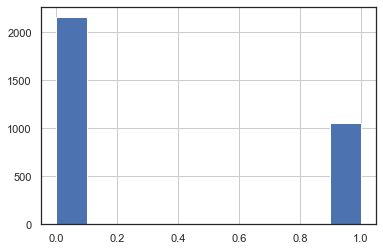

In [619]:
y_P4.hist()

In [620]:
X_P5, y_P5 = X, (Y_data['return'] < -0.20).astype('int')

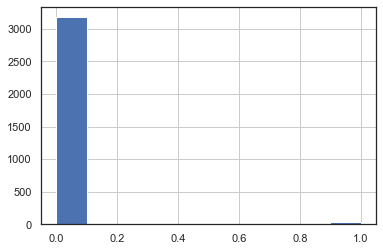

In [621]:
y_P5.hist()

In [622]:
X_P6, y_P6 = X, Y_data.closeDay1

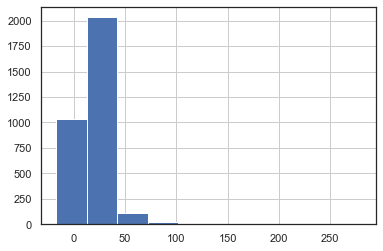

In [623]:
y_P6.hist()

In [626]:
X_P7, y_P7 = X, Y_data.raisingPrice

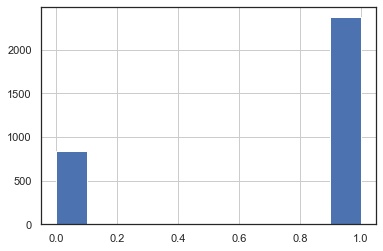

In [627]:
y_P7.hist()

In [629]:
X_P8, y_P8 = X, Y_data.raisingPrice

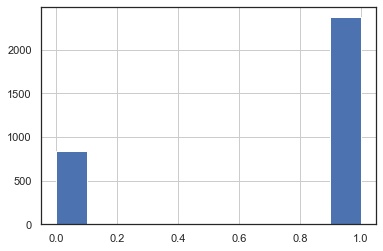

In [631]:
y_P8.hist()

In [632]:
X_P9, y_P9 = X, (Y_data['return'] < -0.10).astype('int')

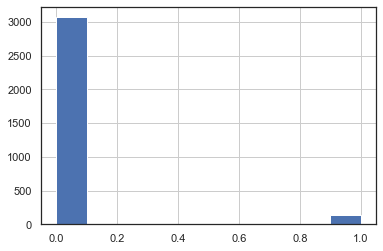

In [633]:
y_P9.hist()

# Part 3: Feature reduction

Reduce features using PCA, select numeric fields for PCA

In [402]:
# Select features for PCA
data_pca = X.select_dtypes([np.number])
len(data_pca.columns)

60

In [403]:
data_pca.head(3)

,egc,html,patRatio,highTech,age,year,nUnderwriters,sharesOfferedPerc,totalProceeds,investmentReceived,...,"industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)",rf_0,rf_1,rf_2,rf_3,rf_4,rf_5,rf_6,rf_7,rf_8
issuer,,,,,,,,,,,,,,,,,,,,,
Numerical Technologies Inc,0,0,0.492063,1,5.0,2000,14,30.50,68114956,64190.000000,...,0,0.001304,0.048072,0.000148,0.766615,0.002614,0.000118,0.002031,0.178794,0.000304
"Home BancShares Inc,Conway,AR",0,1,0.447917,0,8.0,2006,4,17.09,45000000,172172.815261,...,0,0.000451,0.000135,0.000137,0.000124,0.000144,0.000119,0.002460,0.000135,0.996295
Boise Cascade Co,0,1,0.447917,0,9.0,2013,8,27.21,247058826,615284.000000,...,0,0.563837,0.000129,0.001749,0.000118,0.002749,0.000113,0.036224,0.002030,0.393052


In [404]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(data_pca, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

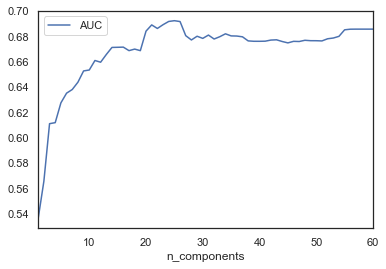

In [405]:
# Explore and print out results for the relationship between AUC and the number of PCA Component Features
estimators = []
estimators.append(('standardize', StandardScaler()))
pca = PCA()
estimators.append(('pca', pca))
estimators.append(('model', LogisticRegression()))
pipeline = Pipeline(estimators)

results = []
for c in range(1,61):
    pipeline.set_params(pca__n_components=c)
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )

df_auc_vs_pca = pd.DataFrame(results, columns=['AUC', 'n_components'])

df_auc_vs_pca.plot('n_components', 'AUC')
plt.savefig('pca_n_components.png')

In [406]:
cum_explained = np.cumsum(pca.explained_variance_ratio_)
cum_explained

array([0.11753714, 0.22517411, 0.28979238, 0.33005761, 0.36941196,
       0.40176643, 0.43100372, 0.45868277, 0.48393933, 0.50692986,
       0.52862314, 0.54975911, 0.57007819, 0.58966369, 0.60890357,
       0.62768342, 0.64632599, 0.66419372, 0.68136053, 0.69821046,
       0.71446216, 0.73038371, 0.74585899, 0.76044673, 0.77492971,
       0.78884979, 0.80257941, 0.81610281, 0.82943404, 0.84250684,
       0.85531665, 0.86767773, 0.87931479, 0.89031171, 0.90089012,
       0.91098329, 0.92030953, 0.92883704, 0.93677829, 0.94391108,
       0.9508457 , 0.95742166, 0.96374513, 0.96959502, 0.97478549,
       0.97974803, 0.98443059, 0.98809928, 0.99149345, 0.99478213,
       0.99654166, 0.99815809, 0.99906716, 0.99964555, 0.99985687,
       0.99995328, 1.        , 1.        , 1.        , 1.        ])

In [407]:
param_grid = {
    'pca__n_components': range(1, 45),
    'model__C': range(1, 10),
}
search = GridSearchCV(pipeline, param_grid, iid=False, cv=5)
search.fit(X_train_train, y_train_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.750):
{'model__C': 4, 'pca__n_components': 13}


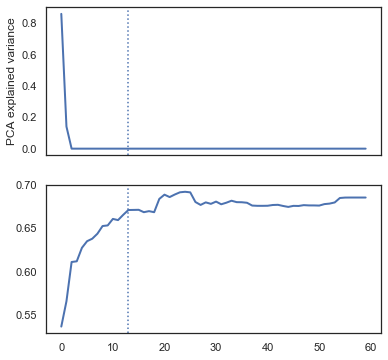

In [408]:
# Plot the PCA spectrum
pca.fit(X_train_train)
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(6, 6))
ax0.plot(pca.explained_variance_ratio_, linewidth=2)
ax0.set_ylabel('PCA explained variance')

ax0.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')

ax1.plot(df_auc_vs_pca.AUC, linewidth=2)
ax1.axvline(search.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.savefig('pca_explained_variance.png')

**Commets**: We select no_components for PCA as 13 based on the above charactersitic.

# Part 4: Training, tuning, and testing of each model

**Steps**:

    Select appropriate features for each model

    pipelining and hyper-parameter tunining (as appropriate)

    baseline model comparisons

    advanced model comparisons between different model typre

    ensembles

    descriptions and explanations of which model is best for each predicition problem

    discussion of additional tasks or improvements that might boost performance

## 0. Random guessing model

### Select data

In [409]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [410]:
y_hat_random = [np.random.choice([0, 1]) for v in y_test]
pd.Series(y_hat_random).value_counts()

1    338
0    305
dtype: int64

### Test the model (AUC, ROC....etc)

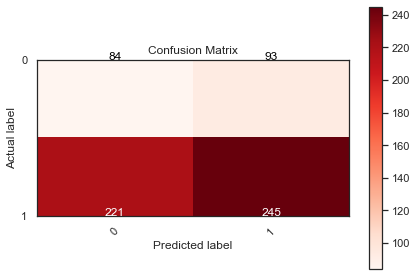

In [411]:
cm_random = confusion_matrix(y_test, y_hat_random)  
plot_confusion_matrix(cm_random)

In [412]:
# Calculate accuracy
accuracy_random = 1 - ((cm_random[0][1] + cm_random[1][0])/(cm_random[0][1] + cm_random[1][0] + cm_random[1][1] + cm_random[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_random))

Accuracy   = 0.5117


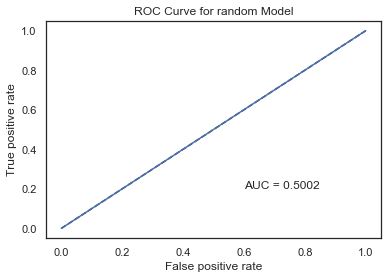

In [413]:
#plot roc curve
fpr_logit_random, tpr_logit_random, _ = roc_curve(y_test, y_hat_random)
best_auc_random = roc_auc_score(y_test, y_hat_random)
plot_roc(fpr_logit_random, tpr_logit_random, 'ROC Curve for random Model', 'AUC = %2.4f' % best_auc_random)

## A. Baseline model

### Select data

In [414]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [415]:
#Look at the most commonly predicted outcome
most_frequent_outcome = Y_data['raisingPrice'].value_counts().idxmax()
print('Most frequent outcome =', most_frequent_outcome)

Most frequent outcome = 1


### Train the model

In [416]:
y_hat_baseline = [most_frequent_outcome ]*len(y_test)
pd.Series(y_hat_baseline).value_counts()

1    643
dtype: int64

### Test the model (AUC, ROC....etc)

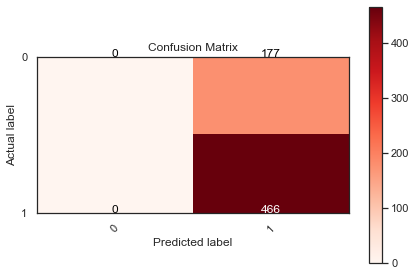

In [417]:
cm_baseline = confusion_matrix(y_test, y_hat_baseline)  
plot_confusion_matrix(cm_baseline)

In [418]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7247


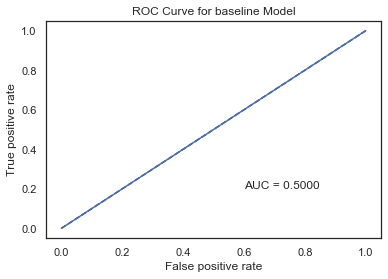

In [419]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_baseline)
best_auc_baseline = roc_auc_score(y_test, y_hat_baseline)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

## B. Linear model

### B1 : Linear model without 'risk factor'

In [587]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X_data, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [588]:
ols_model_p1 = LinearRegression(normalize=True, n_jobs=-1)

In [589]:
y_test.head(3)

issuer
Quintus Corp                    1
Alder BioPharmaceuticals Inc    1
VA Linux Systems Inc            1
Name: raisingPrice, dtype: int64

### Train the model

In [590]:
ols_model_p1.fit(X_train, y_train)
y_hat_ols_prob = ols_model_p1.predict(X_train_val)

### Validation and hyper parameter tuning

In [591]:
results = []
for i in range(1, 100):
    threshold = 0.01 * i
    y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
    correct  = [int(r[0]==r[1]) for r in zip(y_train_val, y_hats)]
    accuracy = sum(correct)/len(correct)
    results.append( (accuracy, threshold) )
optimal_p = sorted(results, reverse=True)[0][1]
print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])

Optimal probability threshold based on accuracy = 0.6000 and the corresponding accuracy is  0.7636080870917574


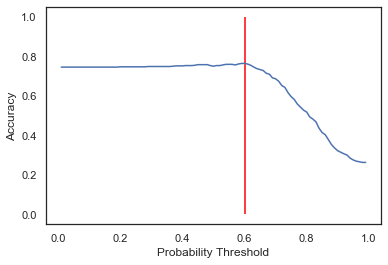

In [592]:
y,x = zip(*results)
plt.plot(x, y)
plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
plt.ylabel('Accuracy')
plt.xlabel('Probability Threshold')
plt.show()

### Test the model (AUC, ROC....etc)

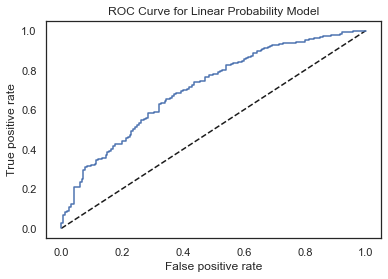

In [593]:
fpr_ols, tpr_ols, _ = roc_curve(y_train_val, y_hat_ols_prob)
auc_ols = roc_auc_score(y_train_val, y_hat_ols_prob)
plot_roc(fpr_ols, tpr_ols, 'ROC Curve for Linear Probability Model')

In [594]:
y_hat_ols_prob_test = ols_model_p1.predict(X_test)
y_hats   = [int(v >= optimal_p) for v in y_hat_ols_prob_test]

In [595]:
auc_ols = roc_auc_score(y_test, y_hats)
print('AUC for linear probability model = %2.4f' % auc_ols)

AUC for linear probability model = 0.5449


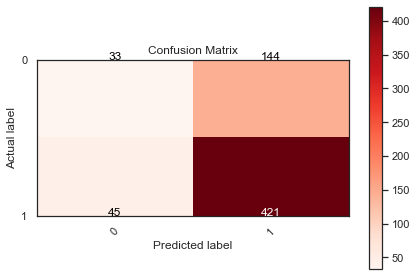

In [596]:
cm_baseline = confusion_matrix(y_test, y_hats)  
plot_confusion_matrix(cm_baseline)

In [597]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7061


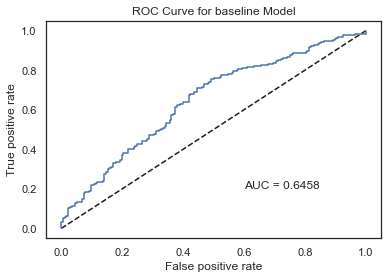

In [598]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_ols_prob_test)
best_auc_baseline = roc_auc_score(y_test, y_hat_ols_prob_test)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

In [600]:
linear_model_p1_final = {'model':ols_model_p1, 'threshold':optimal_p}
linear_model_p1_final

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.6}

### B2: Linear model for precition P2

In [586]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [421]:
ols_model = LinearRegression(normalize=True, n_jobs=-1)

In [422]:
y_test.head(3)

issuer
Quintus Corp                    1
Alder BioPharmaceuticals Inc    1
VA Linux Systems Inc            1
Name: raisingPrice, dtype: int64

### Train the model

In [423]:
ols_model.fit(X_train, y_train)
y_hat_ols_prob = ols_model.predict(X_train_val)

### Validation and hyper parameter tuning

In [424]:
results = []
for i in range(1, 100):
    threshold = 0.01 * i
    y_hats   = [int(v >= threshold) for v in y_hat_ols_prob]
    correct  = [int(r[0]==r[1]) for r in zip(y_train_val, y_hats)]
    accuracy = sum(correct)/len(correct)
    results.append( (accuracy, threshold) )
optimal_p = sorted(results, reverse=True)[0][1]
print('Optimal probability threshold based on accuracy = %2.4f' % optimal_p, 'and the corresponding accuracy is ', sorted(results, reverse=True)[0][0])

Optimal probability threshold based on accuracy = 0.5300 and the corresponding accuracy is  0.7682737169517885


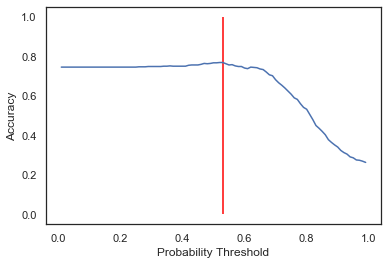

In [425]:
y,x = zip(*results)
plt.plot(x, y)
plt.vlines(optimal_p, ymin=0, ymax=1, colors=['red'])
plt.ylabel('Accuracy')
plt.xlabel('Probability Threshold')
plt.show()

### Test the model (AUC, ROC....etc)

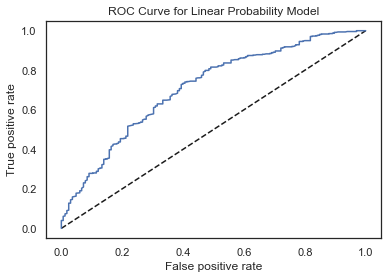

In [426]:
fpr_ols, tpr_ols, _ = roc_curve(y_train_val, y_hat_ols_prob)
auc_ols = roc_auc_score(y_train_val, y_hat_ols_prob)
plot_roc(fpr_ols, tpr_ols, 'ROC Curve for Linear Probability Model')

In [459]:
y_hat_ols_prob_test = ols_model.predict(X_test)
y_hats   = [int(v >= optimal_p) for v in y_hat_ols_prob_test]

In [428]:
auc_ols = roc_auc_score(y_test, y_hats)
print('AUC for linear probability model = %2.4f' % auc_ols)

AUC for linear probability model = 0.5342


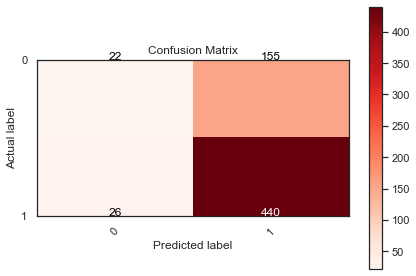

In [429]:
cm_baseline = confusion_matrix(y_test, y_hats)  
plot_confusion_matrix(cm_baseline)

In [430]:
# Calculate accuracy
accuracy_baseline = 1 - ((cm_baseline[0][1] + cm_baseline[1][0])/(cm_baseline[0][1] + cm_baseline[1][0] + cm_baseline[1][1] + cm_baseline[0][0]))
print('Accuracy   =', "{0:.4f}".format(accuracy_baseline))

Accuracy   = 0.7185


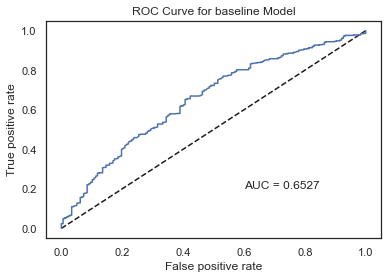

In [460]:
#plot roc curve
fpr_logit_baseline, tpr_logit_baseline, _ = roc_curve(y_test, y_hat_ols_prob_test)
best_auc_baseline = roc_auc_score(y_test, y_hat_ols_prob_test)
plot_roc(fpr_logit_baseline, tpr_logit_baseline, 'ROC Curve for baseline Model', 'AUC = %2.4f' % best_auc_baseline)

In [565]:
linear_model_final = {'model':ols_model, 'threshold':optimal_p}
linear_model_final

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.53}

### Comments on performance and relevance for prediction of P1 to P9

The AUC is above the baseline one, as we could have expected. The accuracy is also better than the baseline one. So this model is probably to simple to get very good results but is not so bad.

## C. Logit model

In [504]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [505]:
estimators = []
estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators.append(('logit_model_l1', LogisticRegression()))  # tell it to use a logit model
pipeline = Pipeline(estimators) 
pipeline.set_params(logit_model_l1__penalty='l1') 

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('logit_model_l1', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))])

### Train the model

### Validation and hyper parameter tuning

In [506]:
# Tune C  
results = []
for c in np.logspace(-4, 5, 10):
    pipeline.set_params(logit_model_l1__C=c) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml1 = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append( (auc_lml1, c)  )
logit_model_l1 = pipeline.named_steps['logit_model_l1']      # capture model so we can use it later

In [507]:
# View results 
print('C'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, c) in results:
    print('{0:.4f}'.format(c).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

     C             AUC    
      0.0001      0.5000 
      0.0010      0.5000 
      0.0100      0.6237 
      0.1000      0.6817 
      1.0000      0.6861 
     10.0000      0.6863 
    100.0000      0.6865 
   1000.0000      0.6866 
  10000.0000      0.6866 
 100000.0000      0.6867 


In [508]:
best_C=1.0

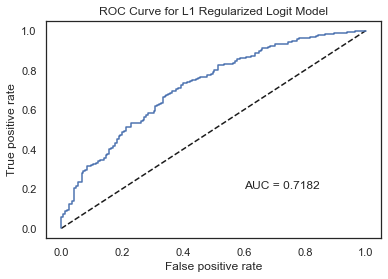

In [510]:
pipeline.set_params(logit_model_l1__C=best_C)
pipeline.fit(X_train,y_train)
y_prob_logit_lasso = pipeline.predict_proba(X_train_val)
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_train_val, y_prob_logit_lasso[:, 1])
best_auc_logit_lasso = roc_auc_score(y_train_val, y_prob_logit_lasso[:,1])
plot_roc(fpr_logit_lasso, tpr_logit_lasso, 'ROC Curve for L1 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_lasso)

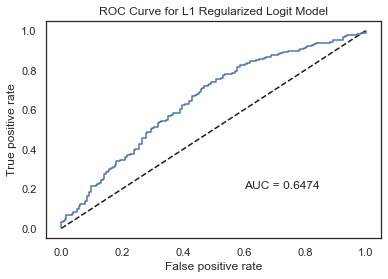

In [512]:
 #Test final model 
pipeline.set_params(logit_model_l1__C=best_C)
pipeline.fit(X_train,y_train)
y_prob_logit_lasso = pipeline.predict_proba(X_test)
fpr_logit_lasso, tpr_logit_lasso, _ = roc_curve(y_test, y_prob_logit_lasso[:, 1])
best_auc_logit_lasso = roc_auc_score(y_test, y_prob_logit_lasso[:, 1])
plot_roc(fpr_logit_lasso, tpr_logit_lasso, 'ROC Curve for L1 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_lasso)

In [513]:
estimators2 = []
estimators2.append(('standardize', StandardScaler()))         # tell it to standardize features
estimators2.append(('ridge', Ridge()))  # tell it to use a logit model
pipeline2 = Pipeline(estimators2) 
#pipeline2.set_params(logit_model_l2__penalty='l2') 

In [514]:
pipeline.get_params()

{'memory': None,
 'steps': [('standardize',
   StandardScaler(copy=True, with_mean=True, with_std=True)),
  ('logit_model_l1',
   LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
             intercept_scaling=1, max_iter=100, multi_class='warn',
             n_jobs=None, penalty='l1', random_state=None, solver='warn',
             tol=0.0001, verbose=0, warm_start=False))],
 'standardize': StandardScaler(copy=True, with_mean=True, with_std=True),
 'logit_model_l1': LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_class='warn',
           n_jobs=None, penalty='l1', random_state=None, solver='warn',
           tol=0.0001, verbose=0, warm_start=False),
 'standardize__copy': True,
 'standardize__with_mean': True,
 'standardize__with_std': True,
 'logit_model_l1__C': 1.0,
 'logit_model_l1__class_weight': None,
 'logit_model_l1__dual': False,
 'logit_model_l1__fit_intercept': True,
 '

In [515]:
# Tune C  
results2 = []
for c in np.logspace(-4, 5, 10):
    pipeline2.set_params(ridge__alpha=c) 
    pipeline2.fit(X_train_train,y_train_train)
    y_train_pred2 = pipeline2.predict(X_train_val)       # use validation set during hyper-parameter tuning
    auc_lml2 = roc_auc_score(y_train_val, y_train_pred2)   
    results2.append( (auc_lml2, c)  )
ridge = pipeline2.named_steps['ridge']      # capture model so we can use it later

In [516]:
# View results 
print('C'.center(12), '   ', 'AUC'.center(8), '\n', '=' * 25)
for (auc, c) in results2:
    print('{0:.4f}'.format(c).rjust(12), '   ',  '{0:.4f}'.format(auc).center(8))

     C             AUC    
      0.0001      0.6857 
      0.0010      0.6857 
      0.0100      0.6857 
      0.1000      0.6858 
      1.0000      0.6861 
     10.0000      0.6860 
    100.0000      0.6847 
   1000.0000      0.6835 
  10000.0000      0.6676 
 100000.0000      0.6534 


In [518]:
best_c=0.100

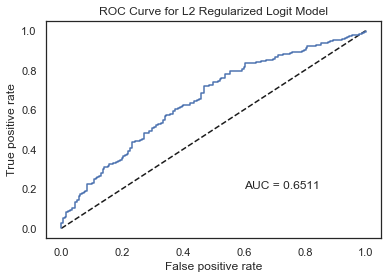

In [521]:
 #Test final model 
pipeline2.set_params(ridge__alpha=best_c)
pipeline2.fit(X_train,y_train)
y_prob_logit_ridge = pipeline2.predict(X_test)
fpr_logit_ridge, tpr_logit_ridge, _ = roc_curve(y_test, y_prob_logit_ridge)
best_auc_logit_ridge = roc_auc_score(y_test, y_prob_logit_ridge)
plot_roc(fpr_logit_ridge, tpr_logit_ridge, 'ROC Curve for L2 Regularized Logit Model', 'AUC = %2.4f' % best_auc_logit_ridge)

### Comparison of logistic models

In [522]:
logit_model = Pipeline([('s', StandardScaler()), ('m', LogisticRegression(penalty='l2', C = 1e10))]).fit(X_train_train, y_train_train).named_steps['m']
print('REGULARIZATION'.center(20), 'NONE'.center(10), 'L1'.center(10))
print('=' * 50)
features = list(set(list(processed_data.columns)) - set(['raisingPrice','rf','closeDay1','offerPrice']))
for (varname, lm_coef, lml1_coef) in zip(features, logit_model.coef_[0], logit_model_l1.coef_[0]):
    lm_coeff  = "{0:.4f}".format(lm_coef).rjust(10)
    lml1_coef = "{0:.4f}".format(lml1_coef).rjust(10) if lml1_coef > 0.0001 else ""
    
    print(str(varname).center(20), lm_coeff, lml1_coef)

   REGULARIZATION       NONE        L1    
    totalAssets          0.1046     0.0828
industryFF12_Consumer Durables -- Cars, TV's, Furniture, Household Appliances     0.0759     0.0350
 nasdaq2weeksBefore     -0.0361 
         pe             -0.0376 
        nVCs             0.1022     0.0988
     prominence         -0.4628 
industryFF12_Chemicals and Allied Products    -0.7880 
industryFF12_Healthcare, Medical Equipment, and Drugs    -0.1469 
        roa             -0.0764 
        age             -0.0334 
 sharesOfferedPerc       0.2433     0.1655
industryFF12_Wholesale, Retail, and Some Services (Laundries, Repair Shops)     0.0303     0.0311
    industryFF48        -0.2315 
 reputationLeadMax       0.2206     0.0528
         vc              0.3702     0.3392
industryFF12_Business Equipment -- Computers, Software, and Electronic Equipment    -0.0038 
      blueSky            0.2886     0.2961
   exchange_NYSE         0.1882     0.2330
     netIncome          -0.1973 
   reputation

In [646]:
#
"""def train_logit_model(X, y, param, param_range):
    # Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
    X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)
    
    estimators = []
    estimators.append(('standardize', StandardScaler()))         # tell it to standardize features
    estimators.append(('logit_model_l1', LogisticRegression()))  # tell it to use a logit model
    pipeline = Pipeline(estimators) 
    pipeline.set_params(logit_model_l1__penalty='l1') 
    
    # Define model
    cv = StratifiedKFold(n_splits=3, shuffle=False, random_state=SEED)

    # Now use the validation_curve() function to train/validate models...
    train_scores, test_scores = validation_curve(pipeline, X_train, y_train, param, param_range, cv=cv, n_jobs=-1)
    
    return pipeline, train_scores, test_scores
    """

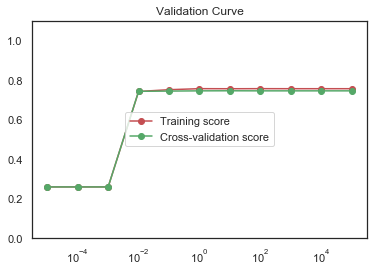

In [644]:
#param, param_range = 'logit_model_l1__C', np.logspace(-5, 5, 11)
#logit_P1, train_score_P1, test_score_P1 = train_logit_model(X_P1, y_P1, param, param_range)
#plot_validation_curve(train_score_P1, test_score_P1, param_range, x_logscale=True)

In [567]:
logit_model_final = copy.deepcopy(pipeline)
logit_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

### Comments on performance and relevance for prediction of P1 to P9

We get a very high auc for the lasso model: it may be good to use it at least for P1

## D. KNN

1. We use KNN for classification purposes. In this section, we build the pipeline to classify positive and negetive cases in the given data set

In [523]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [524]:
# Build pipeline for features except 'rf'
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('knn_model', KNeighborsClassifier()))
pipeline = Pipeline(estimators) 

### Train the model

In [525]:
# Tune K
results = []
for k in range(5, 50, 1):
    pipeline.set_params(knn_model__n_neighbors=k) 
    pipeline.fit(X_train_train,y_train_train)
    y_hat = pipeline.predict_proba(X_train_val)
    auc = roc_auc_score(y_train_val, y_hat[:,1])
    results.append( (auc, k) )
    
# View results 
print('K'.rjust(5), '   ', 'AUC'.center(8), '\n', '=' * 20)
for (auc, k) in results[::10]:
    print('{0}'.format(k).rjust(5), '   ',  '{0:.4f}'.format(auc).center(8))    

    K       AUC    
    5      0.6330 
   15      0.6307 
   25      0.6413 
   35      0.6422 
   45      0.6458 


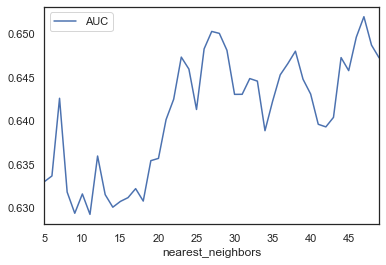

In [526]:
df_auc_knn = pd.DataFrame(results, columns=['AUC', 'nearest_neighbors'])

df_auc_knn.plot('nearest_neighbors', 'AUC')
plt.savefig('knn_n_neighbors_numeric.png')

In [527]:
# Tune K
results = []
for k in range(5, 500, 10):
    pipeline.set_params(knn_model__n_neighbors=k) 
    pipeline.fit(X_train_train,y_train_train)
    y_hat = pipeline.predict_proba(X_train_val)
    auc = roc_auc_score(y_train_val, y_hat[:,1])
    results.append( (auc, k) )
    
# View results 
print('K'.rjust(5), '   ', 'AUC'.center(8), '\n', '=' * 20)
for (auc, k) in results[::10]:
    print('{0}'.format(k).rjust(5), '   ',  '{0:.4f}'.format(auc).center(8))    

    K       AUC    
    5      0.6330 
  105      0.6539 
  205      0.6454 
  305      0.6468 
  405      0.6435 


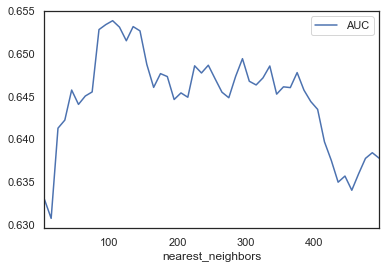

In [528]:
df_auc_knn = pd.DataFrame(results, columns=['AUC', 'nearest_neighbors'])

df_auc_knn.plot('nearest_neighbors', 'AUC')
plt.savefig('knn_n_neighbors_numeric_1.png')

### Validation and hyper parameter tuning

In [450]:
param_grid = {
    'knn_model__n_neighbors': range(1, 15, 1),
}
cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.735):
{'knn_model__n_neighbors': 9}


In [529]:
cv = ShuffleSplit(n_splits=3, test_size=0.25, random_state=SEED)
pipeline.set_params(knn_model__n_neighbors=100)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
print("Scores mean and std: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
scores

Scores mean and std: 0.73 (+/- 0.04)


array([0.74494557, 0.7496112 , 0.69984448])

### Validate the final parameters

In [530]:
# Validation score
y_hat = pipeline.predict_proba(X_train_val)
auc = roc_auc_score(y_train_val, y_hat[:,1])
print(f"AUC : {auc:.3f}")

AUC : 0.652


### Test the model

In [531]:
# Performance on test set
pipeline.fit(X_test,y_test)
y_hat = pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, y_hat[:,1])
print(f"AUC : {auc:.3f}")

AUC : 0.652


In [569]:
knn_model_final = copy.deepcopy(pipeline)
knn_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## E. Decision trees

In [532]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [533]:
# Build pipeline
estimators = []
estimators.append(('DTC_model', DecisionTreeClassifier()))
pipeline = Pipeline(estimators) 


### Train the model

In [534]:
'''# Fit a one-tree Model      
dtc = DecisionTreeClassifier().fit(X_train_train,y_train_train)
y_train_predDT = dtc.predict_proba(X_train_val)
auc_DT = roc_auc_score(y_train_val, y_train_predDT[:,1])
auc_DT'''

'# Fit a one-tree Model      \ndtc = DecisionTreeClassifier().fit(X_train_train,y_train_train)\ny_train_predDT = dtc.predict_proba(X_train_val)\nauc_DT = roc_auc_score(y_train_val, y_train_predDT[:,1])\nauc_DT'

### Validation and hyper parameter tuning

In [535]:
# Tune D   
results = []
for D in range(1,32):
    pipeline.set_params(DTC_model__max_depth=D) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_dtc = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append((auc_dtc, D))

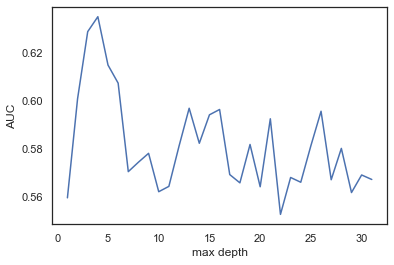

In [536]:
# View results 
df = pd.DataFrame(results)
plt.figure(1)
plt.plot(df[1],df[0])
plt.xlabel('max depth')
plt.ylabel('AUC')
plt.show()

In [537]:
# Select best D
r = np.array(results)
best_D = r[np.argmax(r[:,0]),1]
print ('"best_D" = ', best_D)

"best_D" =  4.0


### Test the model (AUC, ROC....etc)

In [538]:
# Test model
y_test_pred_DT = pipeline.predict_proba(X_test) 
dtc = DecisionTreeClassifier().fit(X_train,y_train)
y_train_predDT = dtc.predict_proba(X_test)
auc_DT = roc_auc_score(y_test, y_train_predDT[:,1])
auc_DT

0.5581884532382824

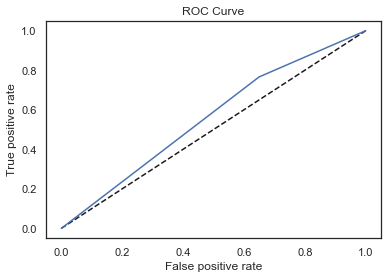

0.5581884532382824


In [539]:
# Plot the ROC
fpr, tpr , _ = roc_curve(y_test, y_train_predDT[:,1])
auc = roc_auc_score(y_test, y_train_predDT[:,1])
plot_roc(fpr, tpr)
print(auc)



In [540]:
# Test final model
#pipeline.set_params(DTC_model__max_depth==int(best_D))
#DTC = pipeline.fit(X_train,y_train)
#y_test_pred_DTC = pipeline.predict_proba(X_test) 

In [541]:
# Plot the ROC

#fpr, tpr , _ = roc_curve(y_test, y_test_pred_DTC[:,1])
#auc = roc_auc_score(y_test, y_test_pred_DTC[:,1])
#plot_roc(fpr, tpr)
#print(auc)

### Comments on performance and relevance for prediction of P1 to P9

In [570]:
decision_trees_model_final = copy.deepcopy(pipeline)
decision_trees_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## F. Random forests

In [542]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
#X = data.loc[:, features]

In [543]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [544]:
# Build pipeline
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('rfc_model', RandomForestClassifier()))
pipeline = Pipeline(estimators) 

### Train the model

### Validation and hyper parameter tuning

In [545]:
# Tune N   
results = []
for N in range(1,250,10):
    pipeline.set_params(rfc_model__n_estimators=N) 
    pipeline.fit(X_train_train,y_train_train)
    y_train_pred = pipeline.predict_proba(X_train_val)       # use validation set during hyper-parameter tuning
    auc_rfc = roc_auc_score(y_train_val, y_train_pred[:,1])   
    results.append((auc_rfc, N))

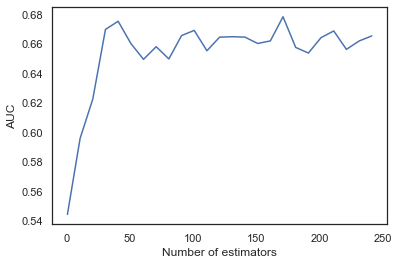

In [546]:
# View results 
df = pd.DataFrame(results)
plt.figure(1)
plt.plot(df[1],df[0])
plt.xlabel('Number of estimators')
plt.ylabel('AUC')
plt.show()

In [547]:
# Select best N
r = np.array(results)
best_N = r[np.argmax(r[:,0]),1]
print ('"best_N" = ', best_N)

"best_N" =  171.0


### Test the model (AUC, ROC....etc)

In [548]:
# Test final model
pipeline.set_params(rfc_model__n_estimators=int(best_N))
RFM = pipeline.fit(X_train,y_train)
y_test_pred_RF = pipeline.predict_proba(X_test) 




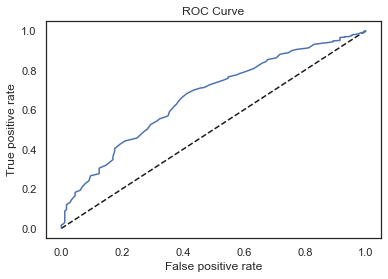

0.6654118474333793


In [549]:
# Plot the ROC

fpr, tpr , _ = roc_curve(y_test, y_test_pred_RF[:,1])
auc = roc_auc_score(y_test, y_test_pred_RF[:,1])
plot_roc(fpr, tpr)
print(auc)


In [571]:
random_forest_model_final = copy.deepcopy(pipeline)
random_forest_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## G. SVC

Using numeric data and SVC classifier for predicting positive and negatve cases

In [572]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, Y_data.raisingPrice, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

In [551]:
# Build pipeline for features except 'rf'
estimators = []
estimators.append(('standardize', StandardScaler()))
estimators.append(('svc', SVC(C=1, probability=True, random_state=SEED)))
pipeline = Pipeline(estimators) 

### Train the model

In [554]:
# Tune K
results = []
for c in np.logspace(-4, 5, 10):
    pipeline.set_params(svc__C=c) 
    pipeline.fit(X_train_train,y_train_train)
    y_hat = pipeline.predict_proba(X_train_val)
    auc = roc_auc_score(y_train_val, y_hat[:,1])
    results.append( (auc, c) )
    

    C       AUC    
0.0001      0.6104 
 10.0      0.6538 


In [556]:
# View results 
print('C'.rjust(5), '   ', 'AUC'.center(8), '\n', '=' * 20)
for (auc, k) in results:
    print('{0}'.format(k).rjust(5), '   ',  '{0:.4f}'.format(auc).center(8))

    C       AUC    
0.0001      0.6104 
0.001      0.6224 
 0.01      0.6466 
  0.1      0.6504 
  1.0      0.6539 
 10.0      0.6538 
100.0      0.6404 
1000.0      0.6313 
10000.0      0.6313 
100000.0      0.6313 


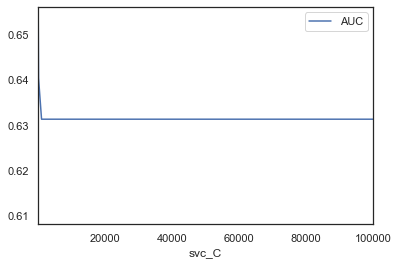

In [555]:
df_auc_svc = pd.DataFrame(results, columns=['AUC', 'svc_C'])

df_auc_svc.plot('svc_C', 'AUC')
plt.savefig('svc_C_numeric.png')

### Validation and hyper parameter tuning

In [ ]:
param_grid = {
    'svc__C': np.arange(1, 6, 1),
}
cv = ShuffleSplit(n_splits=2, test_size=0.25, random_state=SEED)
search = GridSearchCV(pipeline, param_grid, iid=False, cv=cv)
search.fit(X_train, y_train)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

In [557]:
pipeline.set_params(svc__C=1)
scores = cross_val_score(pipeline, X_train, y_train, cv=cv)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.74 (+/- 0.05)


### Validate the final parameters

In [558]:
# Validation score
y_hat = pipeline.predict_proba(X_train_val)
auc = roc_auc_score(y_train_val, y_hat[:,1])
print(f"AUC : {auc:.3f}")

AUC : 0.631


### Test the model

In [559]:
# Performance on test set
pipeline.fit(X_test,y_test)
y_hat = pipeline.predict_proba(X_test)
auc = roc_auc_score(y_test, y_hat[:,1])
print(f"AUC : {auc:.3f}")

AUC : 0.924


In [573]:
svc_model_final = copy.deepcopy(pipeline)
svc_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

## H. Splines

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [ ]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

## I. CNN, RNN etc

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]

In [ ]:
# Use the sklearn train_test_split() function to split data into "train", "validation", and "test" 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,  random_state=SEED)
X_train_train, X_train_val, y_train_train, y_train_val = train_test_split(X_train, y_train, test_size=0.25, random_state=SEED)

### Create model

### Train the model

### Validation and hyper parameter tuning

### Test the model (AUC, ROC....etc)

### Comments on performance and relevance for prediction of P1 to P9

# Part 5: Encembles

Ensemble modeling is a process where multiple diverse base models are used to predict an outcome. ... Even though the ensemble model has multiple base models within the model, it acts and performs as a single model. Most of the practical data science applications utilize ensemble modeling techniques.

# Part 6: Prediction

Prediction based on the predict xls features for each of P1 to P9

For each prediction, be sure to also show appropriate evaluation metrics in your Jupyter notebook. Show the standard metrics presented in class, but also the custom metrics given to you for problems 7, 8, and 9.

Commit and push your predictions (along with your final jupyter notebook file) as part of your project repository.

In [560]:
df_predict=pd.read_excel("IPO_data_to_predict.xlsx")

In [561]:
df_pred_final = copy.copy(df_predict)

## Trained models

In [ ]:
#baseline_model_final

In [574]:
linear_model_final

{'model': LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True),
 'threshold': 0.53}

In [575]:
logit_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

In [576]:
knn_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

In [578]:
decision_trees_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

In [579]:
random_forest_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

In [580]:
svc_model_final

Pipeline(memory=None,
     steps=[('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('svc', SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=1,
  shrinking=True, tol=0.001, verbose=False))])

In [581]:
#Splines

In [582]:
#CNN

In [583]:
classification_models = [linear_model_final['model'], logit_model_final, knn_model_final, decision_trees_model_final, random_forest_model_final, svc_model_final]

## Prediction P1

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use all data from the dataset except for the rf variable (i.e., risk factors).


In [584]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P1 = your prediction

## Prediction P2

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price. You may use only the rf (i.e., risk factors), year, and industryFF12 variables for this prediction task. You may, however, perform additional text analysis of the rf variable.


In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P2 = your prediction

For all remaining problems, you may use any or all of the features.

## Prediction P3

    Predict whether the closing price at the end of the first day of trading will go up (the "positive" case, coded as 1) or down (the "negative" case, coded as 0) from the offer price.


In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P3 = your prediction

## Prediction P4

    Predict whether the closing price at the end of the first day of trading will go up by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P4 = your prediction

## Prediction P5

    Predict whether the closing price at the end of the first day of trading will go down by more than 20% from the original offer price (the "positive" case, coded as 1) or not (the "negative" case, coded as 0).


In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P5 = your prediction

## Prediction P6

    Predict the share price at the end of the first day.


In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P6 = your prediction

For the remaining problems, provide a predicted probability (expressed as a number from 0 to 100) that the stated event will happen.
## Prediction P7

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 5% from the original offer price.

Scoring Metric for P7: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score of p * p (i.e., the square of your predicted probability for that event) will be assessed. For predictions where the event turns out to be TRUE, a score of (100 - p) * (100 - p) will be assessed (i.e., the square of 100 minus your predicted probability for that event). Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, then the score for that observation would equal 4,900 (70 * 70 = 4,900); but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 900 (100 - 70 = 30, and 30 * 30 = 900).

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P7 = your prediction

## Prediction P8

    Predict the probability that the closing price at the end of the first day of trading will go up by more than 50% from the original offer price.

Scoring Metric for P8: Same scoring metric as P7 above. Attempt to tune you prediction model(s) accordingly.

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P8 = your prediction

## Prediction P9

    Predict the probability that the closing price at the end of the first day of trading will go down (the "positive" case, coded as 1) or not (coded as 0) by more than 10% from the original offer price.

Scoring Metric for P9: Your predictions will be evaluated in the following manner (where scored points are bad). For every observation, make a predicted probability, p, ranging from 0 to 100. For predictions where the event turns out to be FALSE, a score equal to p will be assessed. For predictions where the event turns out to be TRUE, a score of 2 * (100 - p) will be assessed. Attempt to tune you prediction model(s) accordingly.

For example: If you predict 70 for an observation that ends up being FALSE, the score for that observation would equal 70; but if you predict 70 for an observation that ends up being TRUE, then the score for that observation would equal 2 * (100 - 70) = 60.

In [ ]:
data = copy.copy(df_predict)

In [ ]:
# Select features 
features = list(set(list(data.columns)) - set(['raisingPrice','rf']))
X = data.loc[:, features]


In [ ]:
# df_pred_final.P9 = your prediction